![Schmankerl Time Machine Logo](https://gitlab.com/cds19-team/cds19/blob/3eef5dbfdbbdc4a00a2b8373c577f63291ca9ce4/Bilder/logo_with_cdv.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from collections import Counter

%matplotlib inline  

In [2]:
REPO_DATA_URL = "https://gitlab.com/cds19-team/cds19/raw/master/"

## Daten importieren

In [3]:
menu_pages = pd.read_csv(REPO_DATA_URL + "Daten/menus.csv")
items = pd.read_csv(REPO_DATA_URL + "Daten/items.csv")
recipies = pd.read_csv(REPO_DATA_URL + "Daten/recipies.csv")
addresses = pd.read_csv(REPO_DATA_URL + "Daten/addresses.csv")
entries = pd.read_csv(REPO_DATA_URL + "Daten/entries.csv")
zones = pd.read_csv(REPO_DATA_URL + "Daten/zones.csv")
categories = pd.read_csv(REPO_DATA_URL + "Daten/categories.csv")
owners = pd.read_csv(REPO_DATA_URL + "Daten/owners.csv")
restaurantes = pd.read_csv(REPO_DATA_URL + "Daten/restaurants.csv")

### Informationen

In [4]:
for dataset in [menu_pages, items, recipies, addresses, entries, zones, categories, owners]:
    print("Columns: {}, Rows: {}".format(dataset.columns.values.tolist(), dataset.shape[0]))

Columns: ['Id', 'Datum', 'Kartentyp', 'Seite', 'Lokaltyp', 'Lokalname', 'Breite_neu', 'Höhe_neu', 'Breite_orig', 'Höhe_orig', 'MD5', 'Dateiname_original'], Rows: 1020
Columns: ['idx', 'description'], Rows: 762
Columns: ['idx', 'item_id', 'recipy_id'], Rows: 163
Columns: ['idx', 'page_id', 'value'], Rows: 16
Columns: ['idx', 'page_id', 'item_id', 'price', 'quantity'], Rows: 848
Columns: ['idx', 'entry_id', 'x1', 'y1', 'x2', 'y2'], Rows: 848
Columns: ['idx', 'page_id', 'value'], Rows: 112
Columns: ['idx', 'page_id', 'value'], Rows: 13


### Bereinigen

In [5]:
menu_pages['Datum'] =  pd.to_datetime(menu_pages['Datum'], errors='coerce')

min_date =  menu_pages['Datum'].min()
max_date = menu_pages['Datum'].max()

idx = pd.to_datetime(pd.date_range(min_date, max_date, freq='Y'), format='%Y-%m-%d').year

## Speisekarten

In [6]:
menus = menu_pages.groupby(['Datum', 'Lokalname']).last().reset_index()
menus.rename(columns={"Seite": "Seiten"}, inplace=True)

nr_restaurants = menus['Lokalname'].nunique()
print("Anzahl Restaurants: {}".format(nr_restaurants))

avg_nr_pages = menus['Seiten'].mean()
print("Durchschnittl. Seiten pro Speisekarte: {0:.2f}".format(avg_nr_pages))

nr_menus_by_restaurant = menus.groupby(['Lokalname']).size().to_frame('count')
print("Durchschnittl. Anzahl Speisekarten pro Restaurant: {0:.2f}".format(nr_menus_by_restaurant.iloc[:,0].mean()))

Anzahl Restaurants: 144
Durchschnittl. Seiten pro Speisekarte: 2.64
Durchschnittl. Anzahl Speisekarten pro Restaurant: 2.25


### Zeitliche Verteilung der Speisekarten

<BarContainer object of 153 artists>

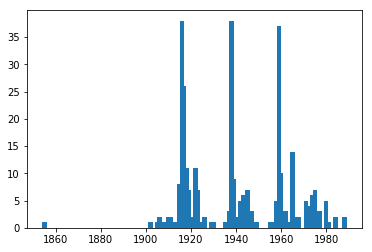

In [7]:
nr_menus_per_year = pd.DataFrame(menus.Datum.groupby([menus.Datum.dt.year]).agg('count'))
nr_menus_per_year.index = pd.to_datetime(nr_menus_per_year.index.astype('int64'), format='%Y').year
nr_menus_per_year = nr_menus_per_year.reindex(idx)

entries = nr_menus_per_year.fillna(0)

ax = plt.figure()
plt.bar(nr_menus_per_year.index, nr_menus_per_year.Datum, 2)

## Gerichte

In [ ]:
# install spacy
!pip install --user spacy
!python -m spacy download de_core_news_md
!pip install --user wordcloud

In [8]:
import spacy

from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image

In [9]:
nlp = spacy.load("de_core_news_md")

In [10]:
# merge all items
custom_stopwords = ['le', 'les', 'la', 'm.','de']

for word in custom_stopwords:
    for w in (word, word[0].capitalize(), word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True
    
corpus = items.description.str.cat(sep=' ')
docx = nlp(corpus)

text_cleaned = " ".join(token.lemma_ for token in docx if not token.is_stop or token.is_punct)

In [11]:
nouns = []

for token in docx:
    if token.is_stop != True and not token.is_punct and token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
        nouns.append(token.lemma_)

adjectives = []

for token in docx:
    if token.is_stop != True and not token.is_punct and token.pos_ == 'ADJ':
        adjectives.append(token.lemma_)

### Häufigste Substantive

In [12]:
noun_counts = Counter(nouns)
for noun in noun_counts.most_common(10):
    print("{} x {}".format(noun[1], noun[0]))

50 x Salat
43 x de
19 x Les
18 x Kraut
18 x Kartoffel
17 x Sauerkraut
16 x Ei
16 x glasen
15 x buttern
14 x La


### Häufigste Adjektive

In [13]:
adj_counts = Counter(adjectives)
for adjective in adj_counts.most_common(10):
    print("{} x {}".format(adjective[1], adjective[0]))

18 x gemischt
15 x hausgemacht
8 x rot
7 x sauern
7 x frischen
7 x frites
7 x wienern
6 x gerieben
6 x gem.
6 x frisch


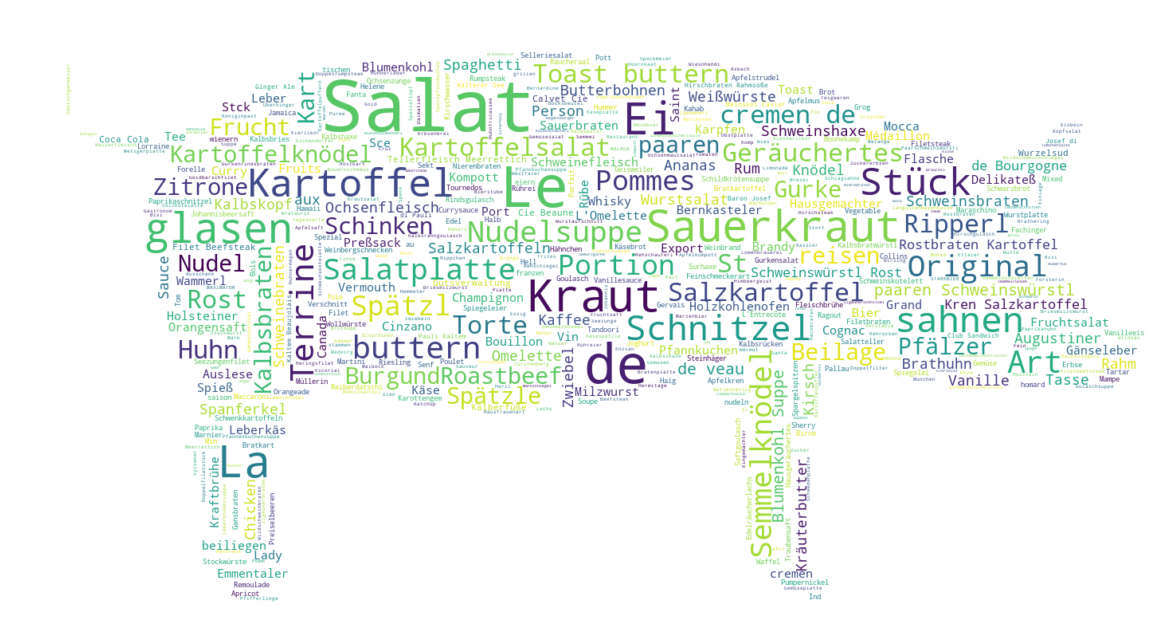

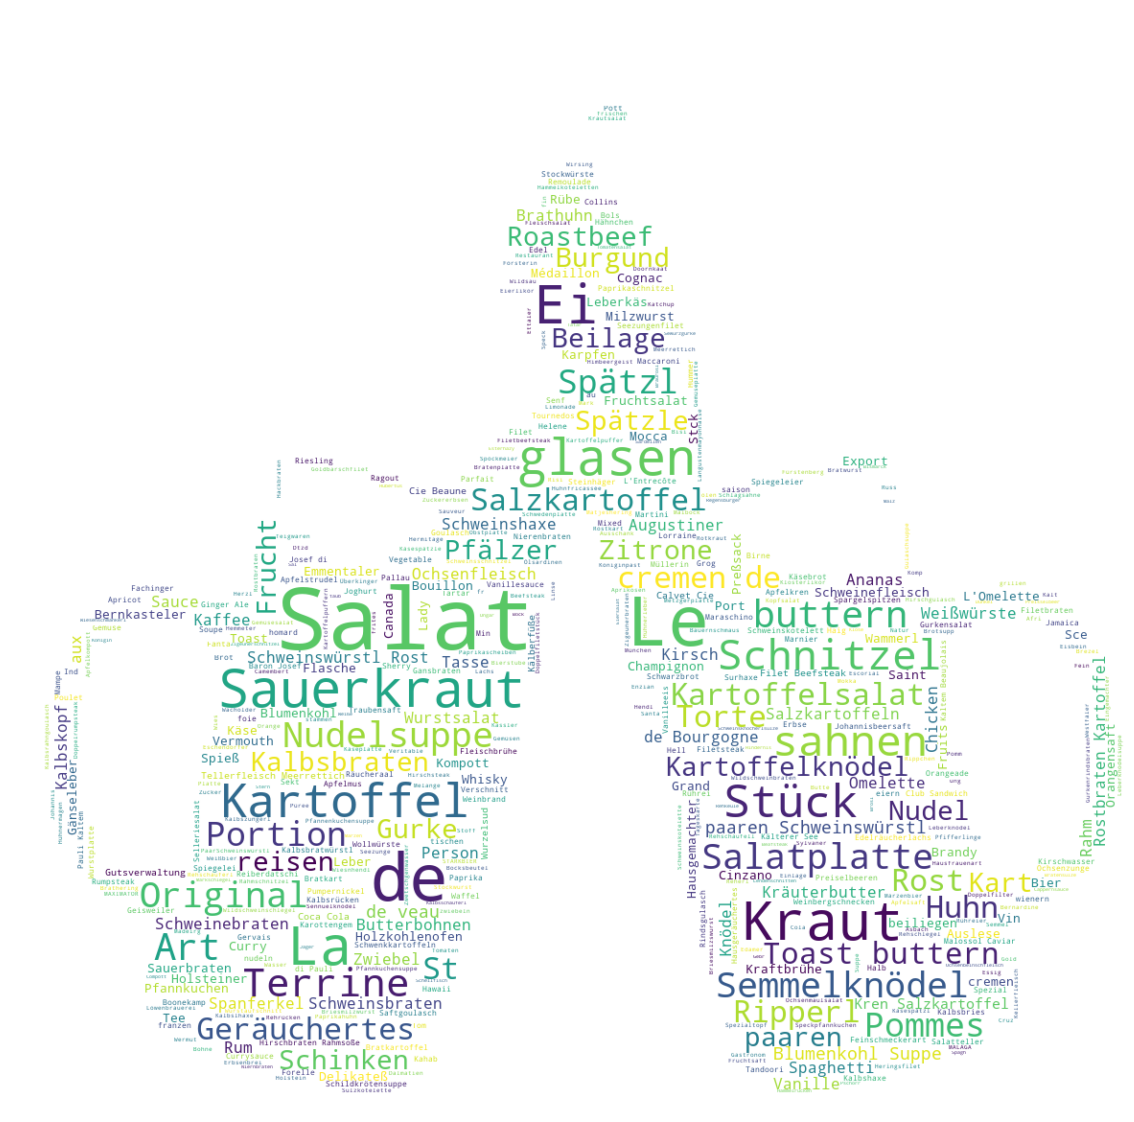

In [17]:
# create word cloud
image_files = ["Notebooks/Bilder/wordcloud_mask_pig.png", "Notebooks/Bilder/wordcloud_mask_beer.png"]

for image_file in image_files:
    mask = np.array(Image.open(requests.get(REPO_DATA_URL + image_file, stream=True).raw))

    wc = WordCloud(background_color='white', max_words=500, mask=mask, max_font_size=90, random_state=42)
    wc.generate(" ".join(nouns))

    plt.figure(figsize=[20,20])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()